In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_sauvola
from tqdm import tqdm

In [13]:
DATA_DIR = '/kaggle/input/datasets/nikhilroxtomar/brain-tumor-segmentation'

In [14]:
image_dir = os.path.join(DATA_DIR, 'images') 
mask_dir = os.path.join(DATA_DIR, 'masks')

In [15]:
def dice_score(pred, true):
    pred = pred.astype(bool)
    true = true.astype(bool)
    intersection = np.logical_and(pred, true).sum()
    return 2. * intersection / (pred.sum() + true.sum() + 1e-8)

def jaccard_score(pred, true):
    pred = pred.astype(bool)
    true = true.astype(bool)
    intersection = np.logical_and(pred, true).sum()
    union = np.logical_or(pred, true).sum()
    return intersection / (union + 1e-8)

In [16]:
otsu_dice_list = []
otsu_jaccard_list = []
sauvola_dice_list = []
sauvola_jaccard_list = []

last_image = None
last_mask = None
last_otsu = None
last_sauvola = None

In [17]:
print(f"Processing images from: {image_dir}")

if os.path.exists(image_dir):
    files = sorted(os.listdir(image_dir))
    
    for filename in tqdm(files):
        if not filename.endswith(".png"):
            continue

        img_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)

        if not os.path.exists(mask_path):
            continue

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            continue

        mask = (mask > 127).astype(np.uint8)

        if mask.sum() == 0:
            continue

        # Pre-processing: CLAHE + Blur
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        image = clahe.apply(image)
        image = cv2.GaussianBlur(image, (5,5), 0)

        # Segmentation
        otsu_thresh = threshold_otsu(image)
        otsu_pred = (image > otsu_thresh).astype(np.uint8)

        sauvola_thresh = threshold_sauvola(image, window_size=51)
        sauvola_pred = (image > sauvola_thresh).astype(np.uint8)

        # Metrics
        otsu_dice_list.append(dice_score(otsu_pred, mask))
        otsu_jaccard_list.append(jaccard_score(otsu_pred, mask))
        
        sauvola_dice_list.append(dice_score(sauvola_pred, mask))
        sauvola_jaccard_list.append(jaccard_score(sauvola_pred, mask))

        last_image = image
        last_mask = mask
        last_otsu = otsu_pred
        last_sauvola = sauvola_pred
else:
    print(f"Error: The directory {image_dir} does not exist.")

Processing images from: /kaggle/input/datasets/nikhilroxtomar/brain-tumor-segmentation/images


100%|██████████| 3064/3064 [02:06<00:00, 24.24it/s]



Otsu Mean Dice:       0.0645
Otsu Mean Jaccard:    0.0341
----------------------------------------
Sauvola Mean Dice:    0.0362
Sauvola Mean Jaccard: 0.0186



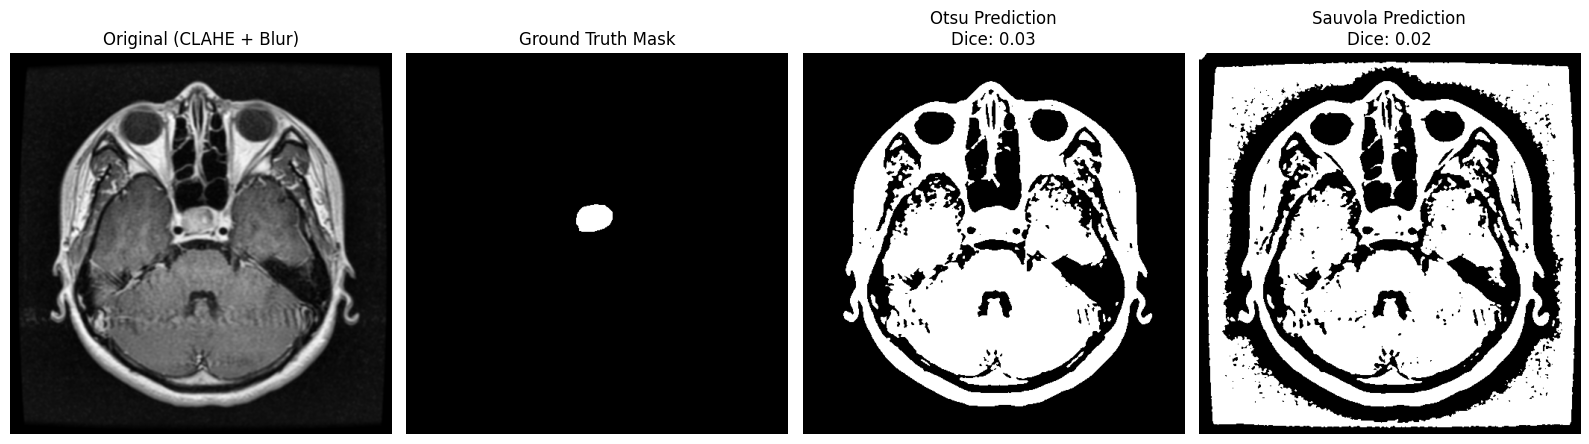

In [21]:
if otsu_dice_list:
    print("\n" + "="*40)
    print(f"Otsu Mean Dice:       {np.mean(otsu_dice_list):.4f}")
    print(f"Otsu Mean Jaccard:    {np.mean(otsu_jaccard_list):.4f}")
    print("-" * 40)
    print(f"Sauvola Mean Dice:    {np.mean(sauvola_dice_list):.4f}")
    print(f"Sauvola Mean Jaccard: {np.mean(sauvola_jaccard_list):.4f}")
    print("="*40 + "\n")

    # Visualization
    plt.figure(figsize=(16, 5))

    # Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(last_image, cmap='gray')
    plt.title("Original (CLAHE + Blur)")
    plt.axis('off')

    # Ground Truth
    plt.subplot(1, 4, 2)
    plt.imshow(last_mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Otsu Result
    plt.subplot(1, 4, 3)
    plt.imshow(last_otsu, cmap='gray')
    plt.title(f"Otsu Prediction\nDice: {otsu_dice_list[-1]:.2f}")
    plt.axis('off')

    # Sauvola Result
    plt.subplot(1, 4, 4)
    plt.imshow(last_sauvola, cmap='gray')
    plt.title(f"Sauvola Prediction\nDice: {sauvola_dice_list[-1]:.2f}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("No images were processed.")

****Result: Both Otsu and Sauvola yielded low overlap scores, indicating that simple thresholding techniques are inadequate for precise brain tumor segmentation. Although Otsu showed slightly better performance, more advanced methods are necessary to achieve reliable results.****